# About This Tutorial

This tutorial explains how to implement Deep Auto-Encoder Model and experiment with it. Deep Auto-Encoder is a deep unsupervised learning model which is widely used to find the structure of the data and extract useful, abstract features. We train the Deep Auto-Encoder with hand-written digits and face image data to investigate the roles of each layer and compare the differences between the layers. This will help you understand the general concept of the deep learning.

The code and comments are written by Jiseob Kim (jkim@bi.snu.ac.kr, https://github.com/nzer0)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Import Libraries
We are going to need the following libraries:
* **numpy**: scientific computing (matrix, algebra, random, etc.)
* **matplotlib**: plotting
* **h5py, cPickle**: efficient data saving and loading
* **theano**: GPU and symbolic computing
* **IPython interact**: scrolled view

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import h5py, cPickle
import theano
import theano.tensor as T
floatX = theano.config.floatX

from IPython.html.widgets import interact # Only works for IPython < 3.x.x. For 4.x.x or above, refer to https://github.com/ipython/ipywidgets

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: no CUDA-capable device is detected)


Populating the interactive namespace from numpy and matplotlib
Couldn't import dot_parser, loading of dot files will not be possible.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Load Data
We use MNIST hand-written digit image data here. It consists of 50k train data, 10k validation data, 10k test data, and their true labels respectively.

In [2]:
hf = h5py.File('mnist.hdf5','r')
print('datasets: {}'.format(hf.keys()))

x_train = theano.shared(hf['x_train'][()])
t_train = theano.shared(hf['t_train'][()])
x_valid = theano.shared(hf['x_valid'][()])
t_valid = theano.shared(hf['t_valid'][()])
x_test  = theano.shared(hf['x_test'][()])
t_test  = theano.shared(hf['t_test'][()])

hf.close()

datasets: [u't_test', u't_train', u't_valid', u'x_test', u'x_train', u'x_valid']


# Check the Train Data

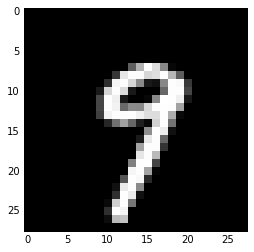

In [3]:
n_data, d_data = x_train.get_value().shape
print('x_train - num of data: {}, dimension: {}'.format(n_data, d_data))
size_w, size_h = 28, 28
print('data shape - (width:{}, height:{})'.format(size_w, size_h))

def viz_image(img):
    plt.imshow(np.reshape(img, (size_w, size_h)), cmap=plt.get_cmap('gray'), interpolation='nearest')
    plt.show()
    
def viz_tile_images(imgs, n_col=10, normalize=True, ax=None):
    num = imgs.shape[0]
    n_row = int((num-1)/n_col)+1
    total_img = np.zeros((n_row*size_h, n_col*size_w))
    for r in xrange(n_row):
        for c in xrange(n_col):
            idx = r*n_col+c
            if idx < num:
                img = np.reshape(imgs[idx], (size_w, size_h))
                if normalize:
                    img = (img - np.min(img))/(np.max(img) - np.min(img))
                total_img[r*size_h:(r+1)*size_h, c*size_w:(c+1)*size_w] = img
    
    orig_fig_size = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (n_col,n_row)
    if ax==None:
        plt.imshow(total_img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else:
        ax.imshow (total_img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    plt.rcParams['figure.figsize'] = orig_fig_size
    
@interact(idx=(0, n_data-1))
def viz_data(idx):
    data = x_train.get_value()[idx]
    viz_image(data)

# Introduction to Stacked Auto-Encoder Model

Stacked Auto-Encoder model is an unsupervised learning model that is trained to encode the raw data with low-dimensional higher-level representation, from which the original data can be recovered (decoded). The model consists of multiple Auto-Encoder models, therefore sometimes called Deep Auto-Encoder. Because of the deep structure, the Stacked Auto-Encoder model is beneficial for learning nonlinear, complex data structures.

The training of Stacked Auto-Encoder is two-fold. Firstly, each Auto-Encoder is trained in layer-wise manner. The lowest Auto-Encoder is trained on the raw data (Figure: left), and the higher-layer Auto-Encoders are trained on the hidden activations data of their one-layer lower Auto-Encoders (Figure: middle). This step is so called **Layer-wise Pre-training**. Secondly, we actually stack the Auto-Encoders to get one large Auto-Encoder. It is sometimes called **Unfolding** (Figure: right). After the unfolding, we can just use the Back-Propagation algorithm to train the model. This step is so called **Fine Tuning**.

<img src="./files/images/sae.jpg" style="width:800px;">

Image from http://dx.doi.org/10.3389/fncom.2015.00032

---

# 1. Auto-Encoder Model

<img src="./files/images/ae_single.png" style="width:400px;">
When the loss function and the parameters are defined, the model can be easily trained using **Back-Propagation**, or essentially, **Gradient Descent** algorithm.

Let $N$ denote the number of data, $d_x$ denote the input dimension and $d_h$ denote the hidden dimension.

$x \in [0,1]^{N \times d_x}, W \in \mathbb{R}^{d_x \times d_h}, b \in \mathbb{R}^{d_h}, a \in \mathbb{R}^{d_x}$

**Hiddens**: $[0,1]^{N \times d_h} \ni h = \sigma (xW+b)$

**Reconstructions**: $[0,1]^{N \times d_x} \ni r = \sigma (hW^T+a)$

**Error**: $L = \frac{1}{N} \sum\limits_{i=0}^{N} \Vert x_i - r_i \Vert ^2$

or $L = - \frac{1}{N} \sum\limits_{i=0}^N \left( x_i \log r_i + (1-x_i) \log (1-r_i) \right)$ 

, where $i$ is a data index

**Regularizer**: $ \Vert W \Vert^2_F $ or $ \frac{1}{N} \sum\limits_{i=0}^N \Vert (\partial h_i / \partial x) \Vert^2_F$

**Paramters**: $W, a, b$

In [4]:
class AE(object):
    def __init__(self, input_var, d_input, d_hidden, lmb=0.1, nick=""):
        '''Input'''
        self.x = input_var
        self.d_input = d_input
        self.d_hidden = d_hidden
        self.lmb = lmb
        '''Parameters'''
        self.W = theano.shared(np.asarray(0.01*np.random.uniform(size=(d_input,d_hidden)), dtype=floatX), 
                               name='W'+nick) # weight
        self.b = theano.shared(np.zeros((d_hidden,), dtype=floatX), name='b'+nick) # hidden bias
        self.a = theano.shared(np.zeros((d_input,), dtype=floatX),  name='a'+nick) # visible bias
        self.params = [self.W, self.b, self.a]
        
    def h(self):
        return T.nnet.sigmoid( T.dot(self.x, self.W) + self.b ) # hidden
    
    def r(self, g=None):
        if g==None:
            g = self.h()
        return T.nnet.sigmoid( T.dot(g, self.W.T) + self.a ) # reconstructed input

    def err(self, g=None, mse=True):
        if mse:
            return T.mean( T.sum((self.x-self.r(g))**2, axis=1), axis=0 )
        else:
            return -T.mean( T.sum(self.x*T.log(self.r(g)) + (1-self.x)*T.log(1-self.r(g)), axis=1) )
    
    def reg(self, reg_method='w_decay'):
        if reg_method=='w_decay':
            return T.sum(self.W**2)
        elif reg_method=='contractive':
            J = T.reshape(self.h()*(1-self.h()), (-1,1,self.d_hidden)) \
                    * T.reshape(self.W, (1,self.d_input,self.d_hidden))
            return T.mean( T.sum(J**2, axis=[1,2]) )
    
    def loss(self, g=None, mse=True, reg_method='w_decay'):
        return self.err(g, mse) + self.lmb*self.reg(reg_method)

# 1.1. Compile the Training Function for Single-Layer Auto-Encoder

### NOTE: If your machine is not powerful enough, skip from here and [go load](#Load-the-Trained-Model) the already-trained model

In [5]:
d_hidden = 200
x = T.matrix('x')
ae = AE(x, d_data, d_hidden, nick="0", lmb=0.1)

def compile_train_func(model, shared_data, batch_size, lr, 
                       g=None, params=None, mse=True, reg_method='w_decay'):
    if params==None:
        params = model.params
    loss = model.loss(g, mse, reg_method)
    grads = T.grad(loss, params)

    i = T.iscalar()
    train_func = theano.function([i], [loss, model.lmb*model.reg(reg_method)],
                                givens={model.x: shared_data[i*batch_size:(i+1)*batch_size]},
                                updates=[(p, p-lr*gr) for p,gr in zip(params,grads)])
    return train_func

AE.compile_train_func = compile_train_func
batch_size = 250
init_lr = np.asarray(0.5, dtype=floatX)
lr = theano.shared(init_lr)
mse = False
reg_method = 'contractive'
train_func = ae.compile_train_func(x_train, batch_size=batch_size, 
                                   lr=lr, mse=mse, reg_method=reg_method)

# 1.2. Train with Learning Rate Decay

epoch: 1, loss: 221.163482666, regularize term: 0.258670657873
epoch: 2, loss: 158.316452026, regularize term: 1.26713347435
epoch: 3, loss: 134.730651855, regularize term: 1.91654038429
epoch: 4, loss: 123.082366943, regularize term: 2.53118491173
epoch: 5, loss: 114.887268066, regularize term: 3.21069335938
epoch: 6, loss: 108.239990234, regularize term: 3.85351443291
epoch: 7, loss: 102.622062683, regularize term: 4.44435691833
epoch: 8, loss: 97.9016571045, regularize term: 4.86454916
epoch: 9, loss: 93.9957046509, regularize term: 5.15152215958
epoch: 10, loss: 90.981552124, regularize term: 5.325091362


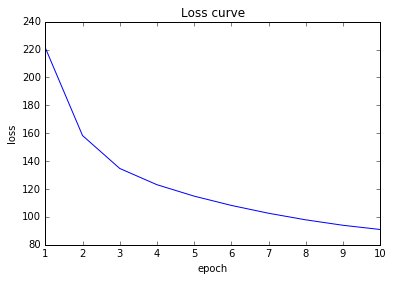

In [6]:
def train(model, train_func, n_epoch, n_batch, lr):

    l_history = []
    W_history = [model.W.get_value()]
    prev_mean_l = np.inf
    for ep in xrange(1,n_epoch+1):
        ls = []
        regs = []
        for bi in xrange(n_batch):
            l, reg = train_func(bi)
            ls.append(l)
            regs.append(reg)
        mean_l = np.mean(ls)
        mean_reg = np.mean(reg)
        print("epoch: {}, loss: {}, regularize term: {}".format(ep, mean_l, mean_reg) )
        if prev_mean_l < mean_l :
            lr.set_value(lr.get_value()*0.5)
            print('Decay lr to {}'.format(lr.get_value()))
        prev_mean_l = mean_l
        l_history.append(mean_l) 
        W_history.append(model.W.get_value())
    
    plt.plot(np.arange(1,n_epoch+1), l_history)
    plt.title('Loss curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
    return l_history, W_history

AE.train = train
n_epoch = 10
n_batch = int(n_data/batch_size)
l_history, W_history = ae.train(train_func, n_epoch=n_epoch, n_batch=n_batch, lr=lr)

# 1.3. Visualize the Trained Model

In [21]:

@interact(ep=(0,n_epoch))
def viz_W_history(ep):
    viz_tile_images(W_history[ep].T)

NameError: name 'n_epoch' is not defined

# 1.4. Visualize the Reconstruction

Top: Original, Bottom: Reconstructed


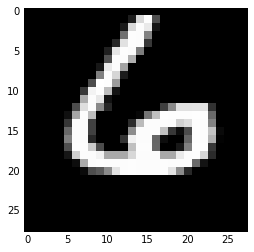

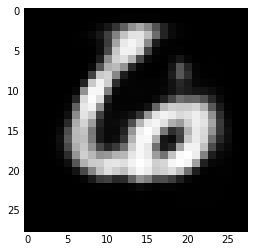

In [9]:
x_data = x_train.get_value()
get_r_data = theano.function([], ae.r(), givens={x:x_train})
r_data = get_r_data()


@interact(idx=(0,n_data))
def viz_recon(idx):
    print("Top: Original, Bottom: Reconstructed")
    viz_image(x_data[idx])
    viz_image(r_data[idx])

# 2. Train the Higher Layer Auto-Encoders (Layer-wise)

Let the already-trained AE model as the first layer of the SAE model. In what follows is to attach the higher layers and train each of them with the lower layers' hidden activation data.

3-Layer Deep Auto-Encoder with Dimensions: [784, 200, 70, 40]
epoch: 1, loss: 55.8405952454, regularize term: 0.369267940521
epoch: 2, loss: 41.1245269775, regularize term: 0.535507142544
epoch: 3, loss: 35.2298622131, regularize term: 0.69501966238
epoch: 4, loss: 31.904756546, regularize term: 0.826589047909
epoch: 5, loss: 29.6814022064, regularize term: 0.939468801022
epoch: 6, loss: 28.0714836121, regularize term: 1.0417406559
epoch: 7, loss: 26.8965435028, regularize term: 1.13303208351
epoch: 8, loss: 26.058757782, regularize term: 1.21142494678
epoch: 9, loss: 25.4526081085, regularize term: 1.27800035477
epoch: 10, loss: 24.9961719513, regularize term: 1.33509278297


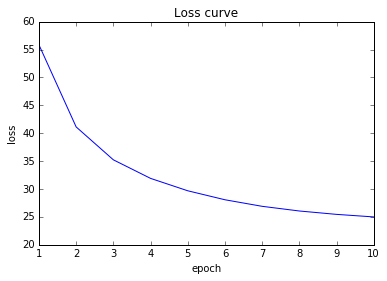

epoch: 1, loss: 41.8546600342, regularize term: 0.105387151241
epoch: 2, loss: 33.620639801, regularize term: 0.231121838093
epoch: 3, loss: 30.1209087372, regularize term: 0.330275386572
epoch: 4, loss: 27.956987381, regularize term: 0.418655067682
epoch: 5, loss: 26.6983985901, regularize term: 0.490672200918
epoch: 6, loss: 25.842748642, regularize term: 0.552534639835
epoch: 7, loss: 25.2323169708, regularize term: 0.604355573654
epoch: 8, loss: 24.7912158966, regularize term: 0.647135913372
epoch: 9, loss: 24.4572162628, regularize term: 0.684180438519
epoch: 10, loss: 24.1907062531, regularize term: 0.717589199543


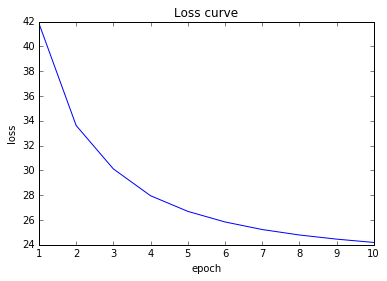

In [10]:
dims = [d_data, d_hidden, 70, 40]
n_layer = len(dims)-1
print("{}-Layer Deep Auto-Encoder with Dimensions: {}".format(n_layer, dims))

aes = [ae]
for li in xrange(1,n_layer):
    aes.append( AE(aes[-1].h(), dims[li], dims[li+1], nick=str(li), lmb=0.04) )
    
get_h_data = theano.function([], ae.h(), givens={ae.x: x_train})
h_datas = [theano.shared(np.asarray(get_h_data(), dtype=floatX), borrow=True)]

for li in xrange(1,n_layer):
    lr.set_value(0.1)
    train_func = aes[li].compile_train_func(h_datas[li-1], batch_size=batch_size, 
                                            lr=lr, mse=mse, reg_method=reg_method)
    aes[li].train(train_func, n_epoch=n_epoch, n_batch=n_batch, lr=lr)
    
    get_h_data = theano.function([], aes[li].h(), givens={aes[li].x: h_datas[li-1]})
    h_datas.append(theano.shared(get_h_data()))
    

# 3. Train the Whole Network (Unfolded)

<img src="./files/images/ae_stacked.png" style="width:400px;">
[See the original Topology](#1.-Auto-Encoder-Model)

Now, we have Auto-Encoders that are trained in a **layer-wise** manner. As a final **fine-tuning** step, we **unfold** the whole network and train it as if it is a single, large auto-encoder.

**Note that this step needs some changes in network structure.** Now each reconstruction $r$ is not generated from $h$ but from the $r$ of the one-layer above. That is, now $g \ne h$, but $g = r'$.

epoch: 1, loss: 117.496330261, regularize term: 4.92017507553
epoch: 2, loss: 111.157997131, regularize term: 4.75200939178
epoch: 3, loss: 108.724494934, regularize term: 4.72035980225
epoch: 4, loss: 107.310340881, regularize term: 4.67459440231
epoch: 5, loss: 106.36756134, regularize term: 4.65260124207
epoch: 6, loss: 105.725097656, regularize term: 4.59176778793
epoch: 7, loss: 104.80544281, regularize term: 4.56439447403
epoch: 8, loss: 104.418708801, regularize term: 4.55569791794
epoch: 9, loss: 104.153411865, regularize term: 4.50045776367
epoch: 10, loss: 103.184715271, regularize term: 4.48372936249
epoch: 11, loss: 103.100898743, regularize term: 4.45674943924
epoch: 12, loss: 102.778244019, regularize term: 4.41409730911
epoch: 13, loss: 102.13432312, regularize term: 4.40977525711
epoch: 14, loss: 102.154884338, regularize term: 4.40187931061
Decay lr to 0.0625
epoch: 15, loss: 98.5083389282, regularize term: 4.42803239822
epoch: 16, loss: 98.0550384521, regularize term:

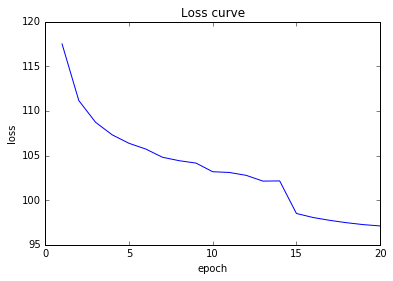

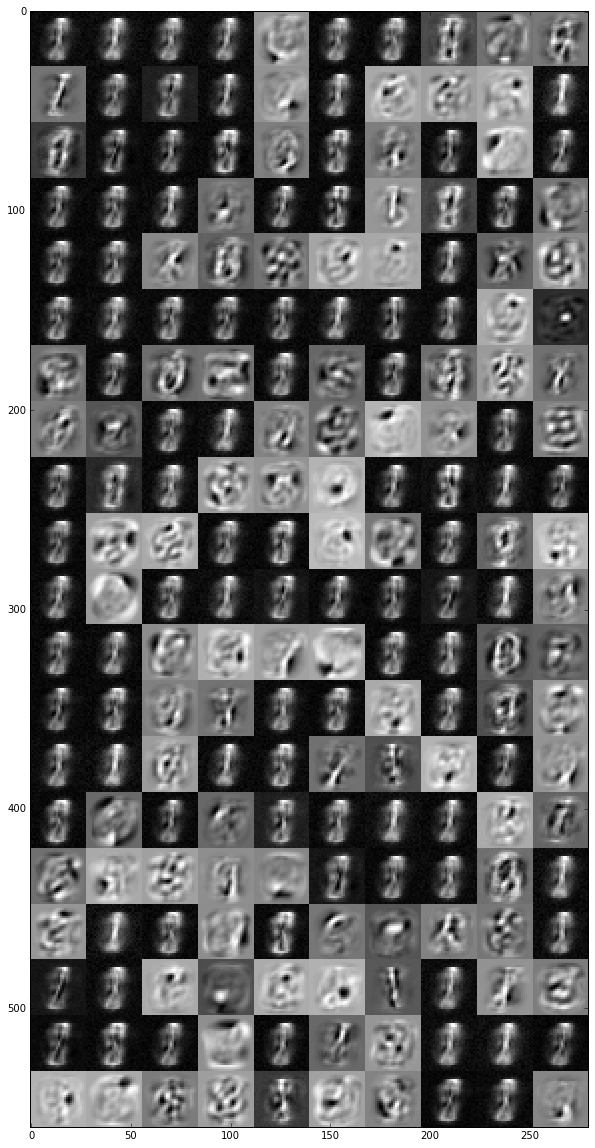

In [11]:
lr.set_value(init_lr*0.25)
params = [p for model in aes for p in model.params]
train_func = aes[0].compile_train_func(x_train, batch_size=batch_size, lr=lr, g=aes[1].r(g=aes[2].r()), 
                                       params=params, mse=mse, reg_method=reg_method)

l_history, W_history = aes[0].train(train_func, n_epoch=20, n_batch=n_batch, lr=lr)

viz_tile_images(aes[0].W.get_value().T)

# Interpolate Two Images

Why do we need a deep architecture? What does the higher layers do? Analyzing the data obtained from the interpolation at different layers, we could get an idea on this.

## The Data Manifold
Many real-world datasets are high-dimensional (several hundreds to thousands). However, not all the dimensions contain independent meanings. In fact, it is known that most of the real-world datasets have very small number of effective dimensionality compared to their presented dimensionality. Utterence data, for example, is very high-dimensional e.g. 100 timesteps, 100 frequency levels would be 10k dimensionality. However, there are only several articulations such that the effective dimensionality is less than 100. MNIST Hand-written digit dataset, which has 784 dimensions, is expected to have ~10 effective dimensionality in similar sense.

The effective structure underlies the dataset is called Data Manifold. The data manifold is mostly non-linear and smooth as depicted as blue surface in the Figure below. The data points are almost always found on the manifold. The Figure shows the case where the dataset is presented in 3-D but effective dimensionality is 2-D (surface).

## Lower-layer and Higher-layer Representations

Lower-layer representation of the Stacked Auto-Encoder or the raw data itself is highly non-linear. You can verify this by interpolating two data points. As you can see in the Figure, the new data created from interpolation most likely exist **off-the-manifold** because the manifold is highly non-linear. Which means the new data does not look like a real hand-written digit data.

<img src="./files/images/lower_layer.png" width="300px">

On the other hand, the Higher-layer representation of the Stacked Auto-Encoder is almost flat (linear). Therefore, if you create a new data by interpolating two data points, it is most likly exist **on-the-manifold**. Which means the new data looks like a real hand-written digit data.

<img src="./files/images/higher_layer.png" width="300px">

As you have seen from the above Figures, higher-layer representations have better structure. Most of the points in this space is expected to be like hand-written digit data. The space also have a low dimensionality, therefore, it is more easy to train a classifier (without curse-of-dimensionality) 


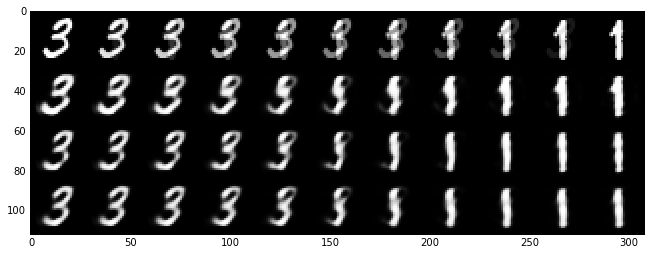

In [6]:
i1 = T.iscalar()
i2 = T.iscalar()
interpolator = np.vstack( (np.linspace(0,1,11), np.linspace(1,0,11)) )
r0 = T.dot(interpolator.T, aes[0].x)
r1 = aes[0].r(g=T.dot(interpolator.T, aes[0].h()))
r2 = aes[0].r(g=aes[1].r(g=T.dot(interpolator.T, aes[1].h())))
r3 = aes[0].r(g=aes[1].r(g=aes[2].r(g=T.dot(interpolator.T, aes[2].h()))))

get_interpolates = theano.function([i1,i2], [r0, r1, r2, r3], givens={aes[0].x: x_train[(i1,i2),:]})
@interact(i1_val=(0,n_data-1), i2_val=(0,n_data-1))
def viz_recon_images(i1_val, i2_val):
    recon_images = get_interpolates(i1_val, i2_val)
    stacked_images = np.vstack(recon_images)
    viz_tile_images(stacked_images, n_col=11)
    plt.show()

# Animated Interpolation
**Note for ttskc docker image users**: You need to install `JSAnimation` by typing the following in the terminal:

```
cd /tensorflow/JSAnimation/
python setup.py install```


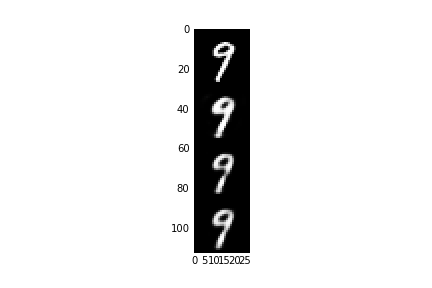
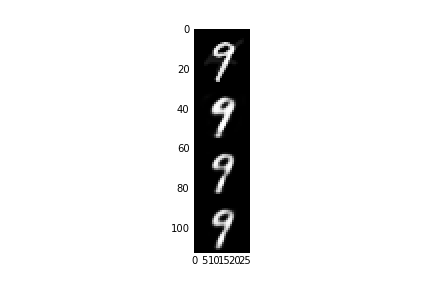
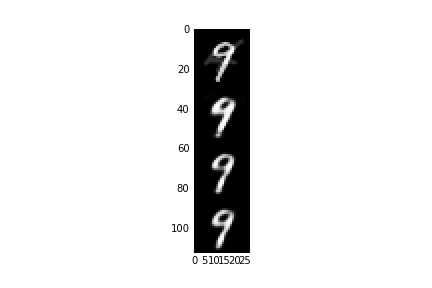
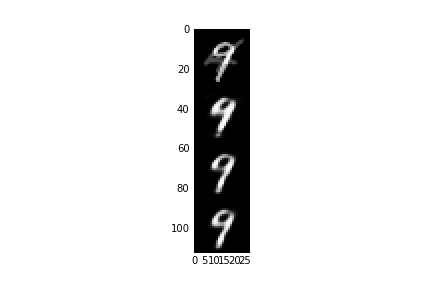
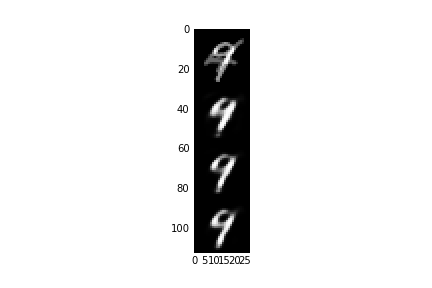
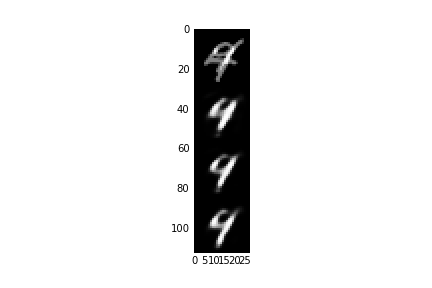
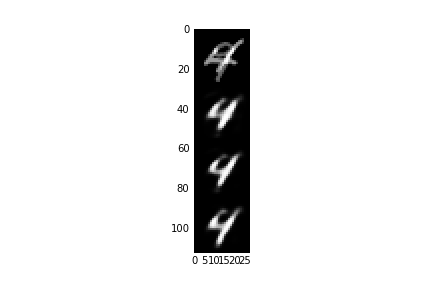
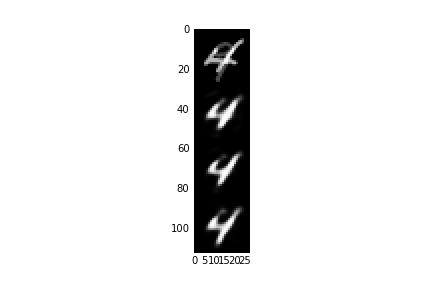
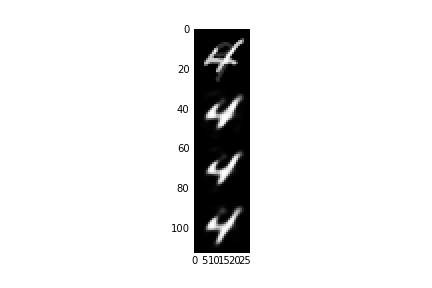
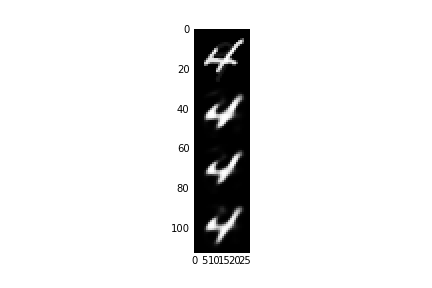
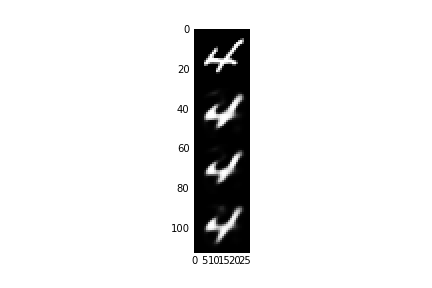

In [7]:
i1_val = 37381
i2_val = 24999
recon_images = get_interpolates(i1_val, i2_val)
stacked_images = np.vstack(recon_images)

from JSAnimation import IPython_display
from matplotlib import animation
fig = plt.figure()
ax = plt.axes()
def init():
    viz_tile_images(stacked_images[np.arange(0,4*11,11)], n_col=1,ax=ax)

def step(i):
    viz_tile_images(stacked_images[np.arange(i,4*11,11)], n_col=1,ax=ax)

animation.FuncAnimation(fig, step, init_func=init,
                    frames=11, interval=100, blit=False)

# Save the Trained Model

In [13]:
# hdf5 method
dump = h5py.File('trained_ae.hdf5','w')
for p in params:
    dump.create_dataset(p.name, data=p.get_value())
print('saved data: {}'.format(dump.keys()))
dump.close()

# pickle method
f = open('trained_ae.pkl', 'wb')
cPickle.dump(aes, f,  protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

saved data: [u'W0', u'W1', u'W2', u'a0', u'a1', u'a2', u'b0', u'b1', u'b2']


# Load the Trained Model

In [5]:
# hdf5 method
d_hidden = 200
x = T.matrix('x')
ae = AE(x, d_data, d_hidden, nick="0", lmb=0.1)

dims = [d_data, d_hidden, 70, 40]
n_layer = len(dims)-1
print("{}-Layer Deep Auto-Encoder with Dimensions: {}".format(n_layer, dims))

aes = [ae]
for li in xrange(1,n_layer):
    aes.append( AE(aes[-1].h(), dims[li], dims[li+1], nick=str(li), lmb=0.04) )
    
    
dump = h5py.File('trained_ae.hdf5','r')
params = [p for model in aes for p in model.params]
for p in params:
    p.set_value(dump[p.name][()])
    
print('loaded data: {}'.format(dump.keys()))
dump.close()

# # pickle method
# f = open('trained_ae.pkl','rb')
# loaded_aes = cPickle.load(f)
# f.close()

3-Layer Deep Auto-Encoder with Dimensions: [784, 200, 70, 40]
loaded data: [u'W0', u'W1', u'W2', u'a0', u'a1', u'a2', u'b0', u'b1', u'b2']
